In [1]:
import numpy as np
import json
from itertools import product

In [2]:
data = json.load(open("output.json"))
data_converged = json.load(open("converged.json"))

In [3]:
current_data = data["active"]["current"]
current_matrix = np.array(current_data["JM"])

transport_data = data["active"]["TransportXS"]
transportXS_matrix = np.array(transport_data["transportXS"])
scatterXS_matrix = np.array(transport_data["scatteringProductionXS"])
fissionXS_matrix = np.array(transport_data["fissionProductionXS"])
flux_matrix = np.array(data["active"]["fluxMap"]["Res"])

# TODO: properly extract spacing
spacing = {"x": 10.0, "y": 10.0, "z": 10.0}

converged_flux = np.array(data_converged["active"]["fluxMap"]["Res"])

In [4]:
flux_matrix.shape

(10, 10, 10, 2, 1, 2)

In [5]:
max_x = len(current_data["XBounds"])
max_y = len(current_data["YBounds"])
max_z = len(current_data["ZBounds"])
max_energy_group = len(transport_data["EnergyBounds"][0])

In [6]:
print(current_matrix.shape)
print(flux_matrix.shape)
print(transportXS_matrix.shape)
print(converged_flux.shape)

print(scatterXS_matrix.shape)
print(fissionXS_matrix.shape)

(1000, 3, 2, 2)
(10, 10, 10, 2, 1, 2)
(10, 10, 10, 2, 2)
(10, 10, 10, 2, 1, 2)
(10, 10, 10, 2, 2, 2)
(10, 10, 10, 2, 2, 2)


In [7]:
def coord_to_multimap_index(x, y, z):
    return z * max_x * max_y + y * max_x + x

def get_current_on_cell_boundary(direction, x, y, z, energy_group):
    # coord, direction, energy, mean/ std
    return current_matrix[coord_to_multimap_index(x, y, z), direction, energy_group, 0]

def get_flux_at_coordinate(x, y, z, energy_group):
    return flux_matrix[z, y, x, energy_group, 0, 0]

def get_transportXS_at_coordinate(x, y, z, energy_group):
    return transportXS_matrix[z, y, x, energy_group, 0]

def get_scatter_xs(energy_to, energy_from, x, y, z):
    # TODO: check this
    return scatterXS_matrix[z, y, x, energy_to, energy_from, 0]

def get_fission_xs(energy_to, energy_from, x, y, z):
    # TODO: check this
    return fissionXS_matrix[z, y, x, energy_to, energy_from, 0]

In [8]:
diffusion_coefficient = np.zeros((max_x, max_y, max_z, max_energy_group))

for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    transport_XS = get_transportXS_at_coordinate(x, y, z, energy)
    if transport_XS == 0:
        continue
    diffusion_coefficient[x, y, z, energy] = 1.0 / transport_XS

In [9]:
# linear cell-to-x coupling in x direction
linear_diffusive_term_x = np.zeros((max_x, max_y, max_z, max_energy_group))
current_contribution_due_to_x_linear_coupling = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if x+1 >= max_x:
        # Cell to boundary coupling
        # TODO, this assumes vacuum boundary conditions
        
        continue

    # Cell-to-cell coupling
    D = diffusion_coefficient[x, y, z, energy]
    D_plus_1 = diffusion_coefficient[x+1, y, z, energy]

    if D == 0 and D_plus_1 == 0:
        continue  # What should happen here?

    coupling = -(2 * D_plus_1 * D)/(spacing["y"]*spacing["z"] * (D_plus_1 + D))

    flux = get_flux_at_coordinate(x, y, z, energy)
    flux_plus_1 = get_flux_at_coordinate(x+1, y, z, energy)

    # TODO: what about the negative direction?
    current_contribution_due_to_x_linear_coupling[x, y, z, energy] = coupling * (flux_plus_1 - flux)
    linear_diffusive_term_x[x, y, z, energy] = coupling


# linear cell-to-y coupling in y direction
linear_diffusive_term_y = np.zeros((max_x, max_y, max_z, max_energy_group))
current_contribution_due_to_y_linear_coupling = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if y+1 >= max_y:
        # TODO: cell to boundary coupling
        continue

    # Cell-to-cell coupling
    D = diffusion_coefficient[x, y, z, energy]
    D_plus_1 = diffusion_coefficient[x, y+1, z, energy]

    if D == 0 and D_plus_1 == 0:
        continue  # What should happen here?

    coupling = -(2 * D_plus_1 * D)/(spacing["y"]*spacing["x"] * (D_plus_1 + D))

    flux = get_flux_at_coordinate(x, y, z, energy)
    flux_plus_1 = get_flux_at_coordinate(x, y+1, z, energy)

    # TODO: what about the negative direction?
    current_contribution_due_to_y_linear_coupling[x, y, z, energy] = coupling * (flux_plus_1 - flux)
    linear_diffusive_term_y[x, y, z, energy] = coupling

# linear cell-to-z coupling in z direction
linear_diffusive_term_z = np.zeros((max_x, max_y, max_z, max_energy_group))
current_contribution_due_to_z_linear_coupling = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if z+1 >= max_z:
        # TODO: cell to boundary coupling
        continue

    # Cell-to-cell coupling
    D = diffusion_coefficient[x, y, z, energy]
    D_plus_1 = diffusion_coefficient[x, y, z+1, energy]

    if D == 0 and D_plus_1 == 0:
        continue  # What should happen here?

    coupling = -(2 * D_plus_1 * D)/(spacing["y"]*spacing["x"] * (D_plus_1 + D))

    flux = get_flux_at_coordinate(x, y, z, energy)
    flux_plus_1 = get_flux_at_coordinate(x, y, z+1, energy)

    # TODO: what about the negative direction?
    current_contribution_due_to_z_linear_coupling[x, y, z, energy] = coupling * (flux_plus_1 - flux)
    linear_diffusive_term_z[x, y, z, energy] = coupling

In [10]:
non_linear_parameter_x = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if x+1 >= max_x:
        # TODO: cell to boundary coupling
        continue

    # Cell-to-cell coupling
    j_linear = current_contribution_due_to_x_linear_coupling[x, y, z, energy]
    flux = get_flux_at_coordinate(x, y, z, energy)
    if flux == 0:
        continue  # TODO: what to do here?

    j_x = get_current_on_cell_boundary(0, x, y, z, energy)
    non_linear_parameter_x[x, y, z, energy] = (j_x - j_linear) / flux

non_linear_parameter_y = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if y+1 >= max_y:
        # TODO: cell to boundary coupling
        continue

    # Cell-to-cell coupling
    j_linear = current_contribution_due_to_y_linear_coupling[x, y, z, energy]
    flux = get_flux_at_coordinate(x, y, z, energy)
    if flux == 0:
        continue  # TODO: what to do here?

    j_y = get_current_on_cell_boundary(1, x, y, z, energy)
    non_linear_parameter_y[x, y, z, energy] = (j_y - j_linear) / flux

non_linear_parameter_z = np.zeros((max_x, max_y, max_z, max_energy_group))
for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    if z+1 >= max_z:
        # TODO: cell to boundary coupling
        continue

    # Cell-to-cell coupling
    j_linear = current_contribution_due_to_z_linear_coupling[x, y, z, energy]
    flux = get_flux_at_coordinate(x, y, z, energy)
    if flux == 0:
        continue  # TODO: what to do here?

    j_z = get_current_on_cell_boundary(2, x, y, z, energy)
    non_linear_parameter_z[x, y, z, energy] = (j_z - j_linear) / flux

In [54]:
# Generate neutron loss matrix
#   NOTE: this assumes all cells are interior

delta_test = 1

number_of_groups = max_x * max_y * max_z * max_energy_group
neutron_loss_matrix = np.zeros((number_of_groups, number_of_groups))

def get_index_in_flattened_flux_vector(energy, x, y, z):
    return energy * (max_x * max_y * max_z) + z * (max_y * max_x) + y * max_x + x

for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    # DONT HANDLE BOUNDARY CONDITIONS
    if x == 0 or y == 0 or z == 0:
        continue
    if x == max_x - 1 or y == max_y - 1 or z == max_z - 1:
        continue

    index_in_flattened_flux_vector = get_index_in_flattened_flux_vector(energy, x, y, z)

    # XXX: non-linear parameter in wrong place + don't use current_contribution_due_to_x_linear_coupling
    # X-direction
    # From flux l-1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x-1, y, z)] \
        += (1 / spacing["x"]) * (-linear_diffusive_term_x[x-1, y, z, energy] - non_linear_parameter_x[x-1, y, z, energy]) \
            + delta_test

    # From flux l
    # TODO: is this a sign error? Also what is the +half
    neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
        += (1 / spacing["x"]) * (linear_diffusive_term_x[x-1, y, z, energy] + linear_diffusive_term_x[x+1, y, z, energy] - non_linear_parameter_x[x-1, y, z, energy] + non_linear_parameter_x[x+1, y, z, energy]) \
            + delta_test

    # From flux l+1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x+1, y, z)] \
        += (1 / spacing["x"]) * (-linear_diffusive_term_x[x+1, y, z, energy] + non_linear_parameter_x[x+1, y, z, energy]) \
            + delta_test

    # Y-direction
    # From flux l-1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x, y-1, z)] \
        += (1 / spacing["y"]) * (-linear_diffusive_term_y[x, y-1, z, energy] - non_linear_parameter_y[x, y-1, z, energy]) \
            + delta_test

    # From flux l
    # TODO: is this a sign error? Also what is the +half
    neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
        += (1 / spacing["y"]) * (linear_diffusive_term_y[x, y-1, z, energy] + linear_diffusive_term_y[x, y+1, z, energy] - non_linear_parameter_y[x, y-1, z, energy] + non_linear_parameter_y[x, y+1, z, energy]) \
            + delta_test

    # From flux l+1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x, y+1, z)] \
        += (1 / spacing["y"]) * (-linear_diffusive_term_y[x, y+1, z, energy] + non_linear_parameter_y[x, y+1, z, energy]) \
            + delta_test

    # Z-direction
    # From flux l-1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x, y, z-1)] \
        += (1 / spacing["z"]) * (-linear_diffusive_term_z[x, y, z-1, energy] - non_linear_parameter_z[x, y, z-1, energy]) \
            + delta_test

    # From flux l
    # TODO: is this a sign error? Also what is the +half
    neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
        += (1 / spacing["z"]) * (linear_diffusive_term_z[x, y, z-1, energy] + linear_diffusive_term_z[x, y, z+1, energy] - non_linear_parameter_z[x, y, z-1, energy] + non_linear_parameter_z[x, y, z+1, energy]) \
            + delta_test

    # From flux l+1
    neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x, y, z+1)] \
        += (1 / spacing["z"]) * (-linear_diffusive_term_z[x, y, z+1, energy] + non_linear_parameter_z[x, y, z+1, energy]) \
            + delta_test

    # Every direction
    neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
        += get_transportXS_at_coordinate(x, y, z, energy) \
            + delta_test

    for energy_group_h in range(max_energy_group):
        neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy_group_h, x, y, z)] \
            -= get_scatter_xs(energy, energy_group_h, x, y, z) - delta_test

neutron_loss_matrix += 0.01 * np.eye(number_of_groups)

In [55]:
# Generate neutron production matrix
neutron_production_matrix = np.zeros((number_of_groups, number_of_groups))

for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
    # DONT HANDLE BOUNDARY CONDITIONS
    if x == 0 or y == 0 or z == 0:
        continue
    if x == max_x - 1 or y == max_y - 1 or z == max_z - 1:
        continue

    index_in_flattened_flux_vector = get_index_in_flattened_flux_vector(energy, x, y, z)
    for energy_group_h in range(max_energy_group):
        neutron_production_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy_group_h, x, y, z)] \
            += get_fission_xs(energy, energy_group_h, x, y, z)

neutron_production_matrix += 0.01 * np.eye(number_of_groups)

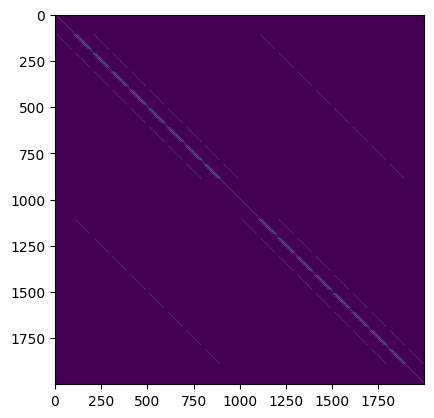

In [56]:
import matplotlib.pyplot as plt

plt.imshow(neutron_loss_matrix != 0)


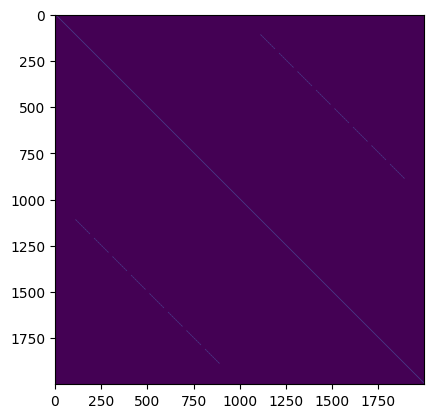

In [57]:
import matplotlib.pyplot as plt

plt.imshow(neutron_production_matrix != 0)


In [52]:
from scipy.linalg import eig

eigenvalues, eigenvectors = eig(neutron_loss_matrix, neutron_production_matrix)


In [34]:
def convert_flattened_flux_into_matrix(flattened_flux):
    matrix = np.zeros((max_x, max_y, max_z, max_energy_group))
    for x, y, z, energy in product(range(max_x), range(max_y), range(max_z), range(max_energy_group)):
        index = get_index_in_flattened_flux_vector(energy, x, y, z)
        matrix[x, y, z, energy] = flattened_flux[index]
        if flattened_flux[index] != 0:
            print(flattened_flux[index])
    return matrix

(112.66472229706518+0j)


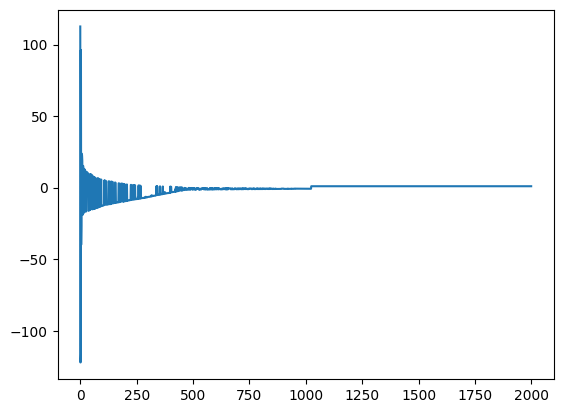

In [53]:
plt.plot(eigenvalues)
print(eigenvalues[0])

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


/tmp/ipykernel_11451/3475549646.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[x, y, z, energy] = flattened_flux[index]


Text(0.5, 1.0, 'Total flux')

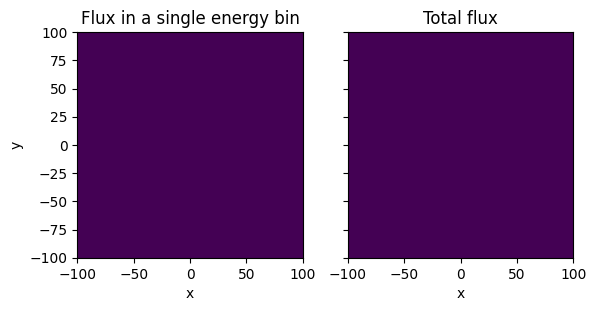

In [42]:
predicted_flux = convert_flattened_flux_into_matrix(eigenvectors[4])


import matplotlib.pyplot as plt

energy_index = 0
total_flux = np.sum(predicted_flux[5, :, :, :], axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

energy_bin = np.array(data["active"]["fluxMap"]["EnergyBounds"]).T[energy_index]

img = ax1.imshow(predicted_flux[5, :, :, energy_index], extent=[-100, 100, -100, 100])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(f"Flux in a single energy bin")

img = ax2.imshow(total_flux, extent=[-100, 100, -100, 100])
ax2.set_xlabel("x")
ax2.set_title("Total flux")

Text(0.5, 1.0, 'Total flux')

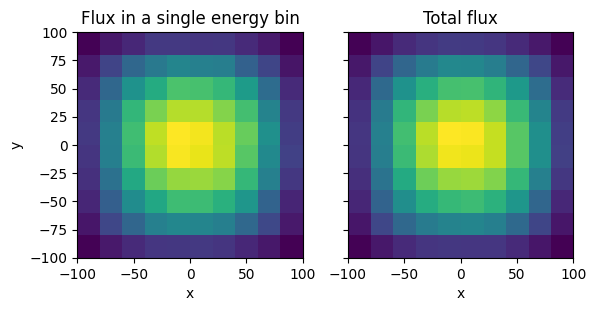

In [19]:
import matplotlib.pyplot as plt

energy_index = 1
total_flux = np.sum(converged_flux[5, :, :, :, 0, 0], axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

energy_bin = np.array(data_converged["active"]["fluxMap"]["EnergyBounds"]).T[energy_index]

img = ax1.imshow(converged_flux[5, :, :, energy_index, 0, 0], extent=[-100, 100, -100, 100])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(f"Flux in a single energy bin")

img = ax2.imshow(total_flux, extent=[-100, 100, -100, 100])
ax2.set_xlabel("x")
ax2.set_title("Total flux")

Text(0.5, 1.0, 'Total flux')

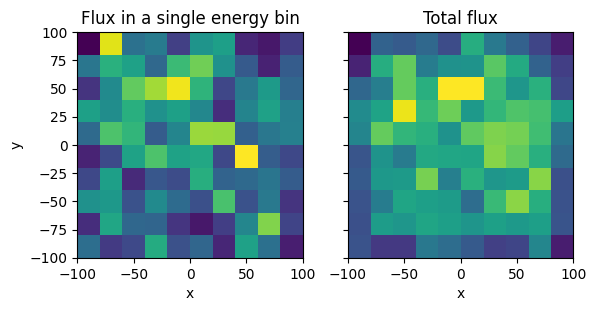

In [20]:
import matplotlib.pyplot as plt


total_flux = np.sum(flux_matrix[5, :, :, :, 0, 0], axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

energy_bin = np.array(data["active"]["fluxMap"]["EnergyBounds"]).T[energy_index]

img = ax1.imshow(flux_matrix[5, :, :, energy_index, 0, 0], extent=[-100, 100, -100, 100])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(f"Flux in a single energy bin")

img = ax2.imshow(total_flux, extent=[-100, 100, -100, 100])
ax2.set_xlabel("x")
ax2.set_title("Total flux")